In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
#pip install scikit-plot
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/Shareddrives/ML and DDR Final Projects/ML Final Project')

In [ ]:
full_data = pd.read_csv("PS_20174392719_1491204439457_log.csv")

# EDA - Check Data Quality

### Feature Description
1. step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
2. type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
3. amount - amount of the transaction in local currency.
4. nameOrig - customer who started the transaction
5. oldbalanceOrg - initial balance before the transaction
6. newbalanceOrig - new balance after the transaction
7. nameDest - customer who is the recipient of the transaction
8. oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
9. newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
10. isFraud - This is the transactions made by the fraudulent agents 
inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
11. isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [ ]:
# Check data types
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
full_data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [ ]:
# check null values
print(full_data.isna().sum())
### This is a clean dataset with no missing values

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


# EDA - Visulizations

Text(0.5, 1.0, 'Confusion matrix for simulator results')

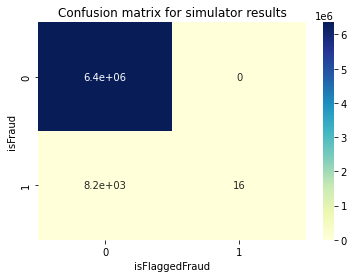

In [ ]:
# evaluate the accuracy of the current flagged rules
y_true = list(full_data['isFraud'])
y_pred = list(full_data['isFlaggedFraud'])
cf_matrix = metrics.confusion_matrix(y_true, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='YlGnBu')
plt.xlabel("isFlaggedFraud")
plt.ylabel("isFraud")
plt.title("Confusion matrix for simulator results")

*   Currently, the company detect fredulent activities using the amount of transactions. An attempt to transfer more than 200.000 will be flagged as a fredulent activity. The accuracy of this approach is poor. It only catches only 16 fraud and fails to capture 8200 fraud cases
*   Among all the cases, only 8200 falls in categories.



Text(0.5, 1.0, 'Types of Fraudulent Transcations')

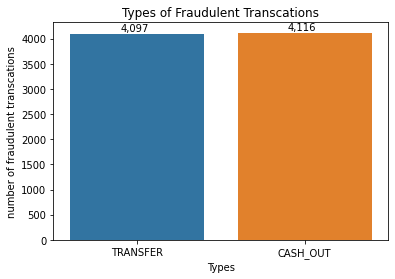

In [ ]:
# explore the types of fraudulent transactions
df_fraud = full_data[full_data['isFraud']==1]
ax = sns.countplot(x='type', data=df_fraud)
plt.ylabel('number of fraudulent transcations')
plt.xlabel('Types')
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x()+0.3, p.get_height()*1.01))
plt.title('Types of Fraudulent Transcations')

There are only two types of transactions falling under fraud category -- Transfer and Cash-out.

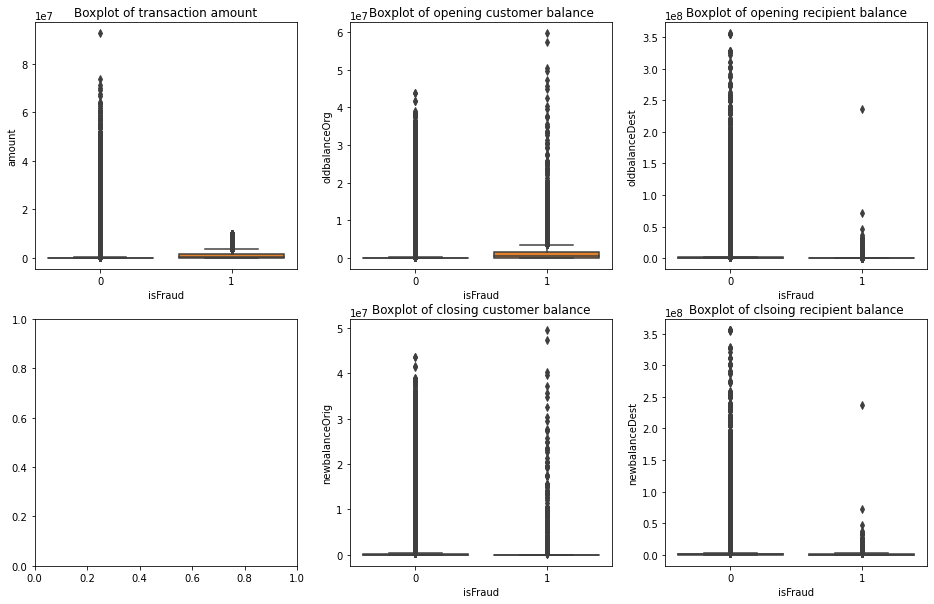

In [ ]:
fig,axs = plt.subplots(2,3,figsize=(16,10))
axs[0][0].title.set_text('Boxplot of transaction amount')
sns.boxplot(x=full_data.isFraud, y=full_data.amount,ax=axs[0][0]) #(1,1)
axs[0][1].title.set_text("Boxplot of opening customer balance")
sns.boxplot(x=full_data.isFraud, y=full_data.oldbalanceOrg,ax=axs[0][1]) #(1,2)
axs[1][1].title.set_text("Boxplot of closing customer balance")
sns.boxplot(x=full_data.isFraud, y=full_data.newbalanceOrig,ax=axs[1][1]) #(2,2)
axs[0][2].title.set_text("Boxplot of opening recipient balance")
sns.boxplot(x=full_data.isFraud, y=full_data.oldbalanceDest,ax=axs[0][2]) #(1,3)
axs[1][2].title.set_text("Boxplot of clsoing recipient balance")
sns.boxplot(x=full_data.isFraud, y=full_data.newbalanceDest,ax=axs[1][2]) #(2,3)
plt.show()

There are a lot of outlinears for amount, open and close amount of customer and recipient. We cannot simply delete the outliers because they may be the signals of fraudulent activities.

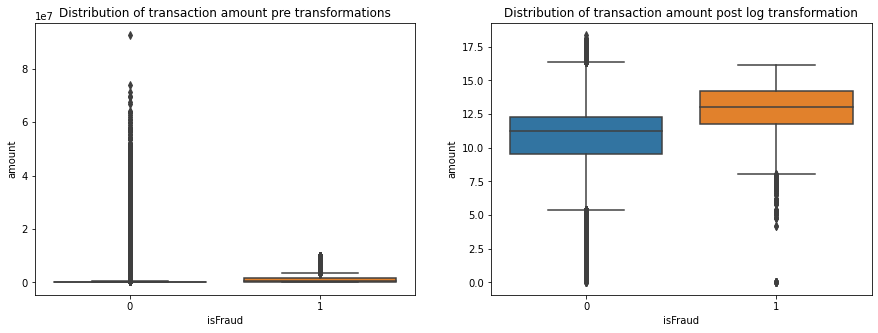

In [ ]:
# the effect of log transformation
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text("Distribution of transaction amount pre transformations")
ax[1].title.set_text("Distribution of transaction amount post log transformation")
sns.boxplot(x=full_data.isFraud, y=full_data.amount,ax=ax[0])
sns.boxplot(x=full_data.isFraud,y=np.log1p(full_data.amount),ax=ax[1])
plt.show()

As mentioned above, there is a need of outlier treatment in the quantitative variables. One of the most popular ways is to apply log transformation. For transformation, Log(1+x) is a decent one when there are zeroes present in the variable. From the graph, we can tell that log transofrmation spread the data which originally clustering on the bottom.

<BarContainer object of 2 artists>

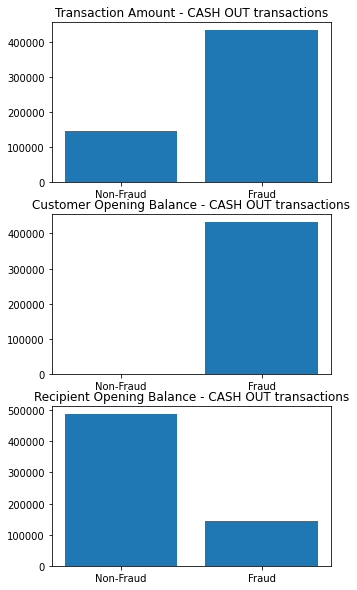

In [ ]:
fig,ax=plt.subplots(3,figsize=(5,10))
ax[0].title.set_text("Transaction Amount - CASH OUT transactions")
ax[0].bar(x=["Non-Fraud","Fraud"],height=full_data[full_data.type=="CASH_OUT"].groupby("isFraud")["amount"].median()) # (1,1)

ax[1].title.set_text("Customer Opening Balance - CASH OUT transactions")
ax[1].bar(x=["Non-Fraud","Fraud"],height=full_data[full_data.type=="CASH_OUT"].groupby("isFraud")["oldbalanceOrg"].median()) #(1,2)

ax[2].title.set_text("Recipient Opening Balance - CASH OUT transactions")
ax[2].bar(x=["Non-Fraud","Fraud"],height=full_data[full_data.type=="CASH_OUT"].groupby("isFraud")["oldbalanceDest"].median()) #(1,3)

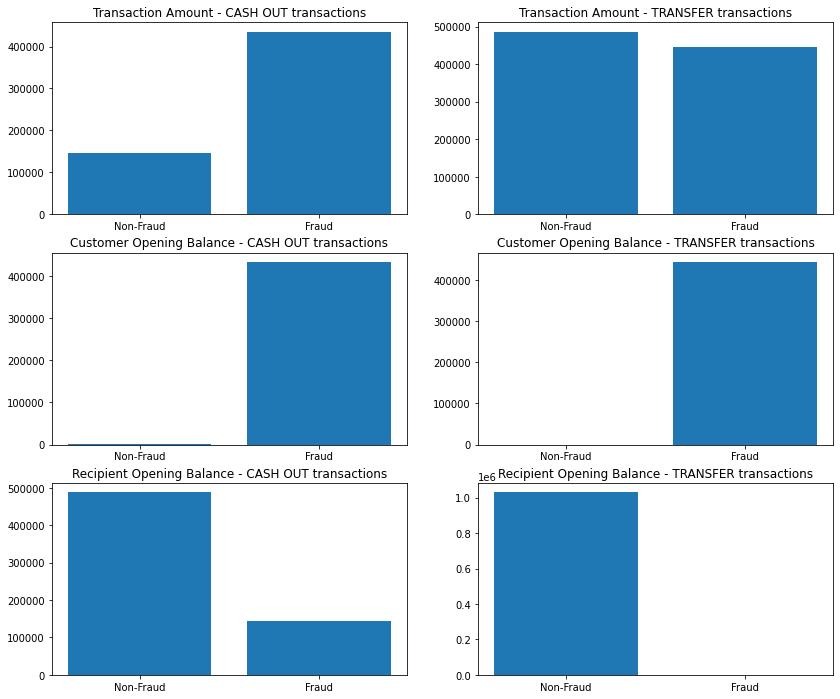

In [ ]:
fig,ax=plt.subplots(3,2,figsize=(14,12))
ax[0][0].title.set_text("Transaction Amount - CASH OUT transactions")
ax[0][0].bar(x=["Non-Fraud","Fraud"],height=full_data[full_data.type=="CASH_OUT"].groupby("isFraud")["amount"].median()) # (1,1)

ax[1][0].title.set_text("Customer Opening Balance - CASH OUT transactions")
ax[1][0].bar(x=["Non-Fraud","Fraud"],height=full_data[full_data.type=="CASH_OUT"].groupby("isFraud")["oldbalanceOrg"].median()) #(2,1)

ax[2][0].title.set_text("Recipient Opening Balance - CASH OUT transactions")
ax[2][0].bar(x=["Non-Fraud","Fraud"],height=full_data[full_data.type=="CASH_OUT"].groupby("isFraud")["oldbalanceDest"].median()) #(3,1)

ax[0][1].title.set_text("Transaction Amount - TRANSFER transactions")
ax[0][1].bar(x=["Non-Fraud","Fraud"],height=full_data[full_data.type=="TRANSFER"].groupby("isFraud")["amount"].median()) # (1,2)

ax[1][1].title.set_text("Customer Opening Balance - TRANSFER transactions")
ax[1][1].bar(x=["Non-Fraud","Fraud"],height=full_data[full_data.type=="TRANSFER"].groupby("isFraud")["oldbalanceOrg"].median()) #(2,2)

ax[2][1].title.set_text("Recipient Opening Balance - TRANSFER transactions")
ax[2][1].bar(x=["Non-Fraud","Fraud"],height=full_data[full_data.type=="TRANSFER"].groupby("isFraud")["oldbalanceDest"].median())#(3,2)
fig.show()

Here we drill down transaction amount, customer opending balance, and recipient openning balance by CASH OUT and TRANSFER. We used median rather than mean to avoid the effect of outliers. We noticed that transaction amount and customer opending balance of CASH OUT are abnormally high for fraud cash-out transactions compared to non-fraud cash-out transactions, while that for recipient openning balance is reversed.

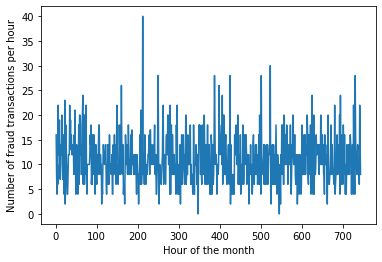

In [ ]:
sns.lineplot(x=list(range(1,744)),y=full_data.groupby("step")["isFraud"].sum())
plt.xlabel("Hour of the month")
plt.ylabel("Number of fraud transactions per hour")
plt.show()


Above is the fraud happened in 744 hours recorded in the dataset. We can see that there are peaks near to each other, which indicates that fraud activities happened frequently and take a short amount of time to complete

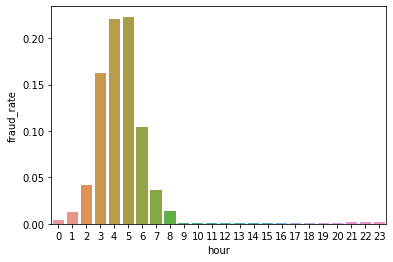

In [ ]:
full_data["hour"] = full_data.step % 24
frauds_hour = pd.concat([full_data.groupby("hour")["isFraud"].sum(),full_data.groupby("hour")["isFraud"].count()],axis=1)
frauds_hour.columns = ["Frauds","Transactions"]
frauds_hour["fraud_rate"] = frauds_hour.Frauds/frauds_hour.Transactions
sns.barplot(x=frauds_hour.index,y=frauds_hour.fraud_rate)
plt.show()

From the step variable, we can get the hour of day. The graph above shows the fraud rate at different hours of day. It tells that frauds happen during sleeping hours the most. More than 20% of the transactions that happen during 4 AM and 5 AM are fraud transactions.

In [ ]:
full_data.loc[full_data.isFlaggedFraud==1, :]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1,20
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1,10
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1,15
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1,3
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1,17
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1,17
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1,2
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1,10
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1,17
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1,22


In [ ]:
full_data_2= pd.get_dummies(full_data, columns=['type', 'hour'], drop_first=True)
full_data_2=full_data_2.drop(['step', 'isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1)

In [ ]:
X= full_data_2.loc[:, full_data_2.columns != 'isFraud']
y = full_data_2['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,hour_1,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
4644207,607193.64,15458649.28,16065842.92,3394537.70,2787344.06,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3800666,3473.75,0.00,0.00,0.00,0.00,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4426240,66170.69,32803.00,0.00,0.00,66170.69,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5788765,335384.26,197.00,0.00,5311958.61,5647342.87,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2010701,234392.25,20882.00,255274.25,0.00,0.00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3408852,78143.26,209723.00,131579.74,249352.15,327495.41,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2756286,4972.33,0.00,0.00,0.00,0.00,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3167668,13096.24,5638.00,0.00,0.00,13096.24,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3337309,96814.92,0.00,0.00,1607329.85,1704144.76,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
count=0
for x in list(y_test):
  if (x==1):
    count+=1

1641

In [ ]:
model_logit = LogisticRegression().fit(X_train, y_train)
y_pred= model_logit.predict(X_test)
y_prob=model_logit.predict_proba(X_test)

#cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

TNR = tn/(tn+fp)
TPR = tp/(tp+fn)

print(classification_report(y_test, y_pred))
#skplt.metrics.plot_roc_curve(y_test, y_prob)
#plt.show()
count=0
for x in list(y_pred):
  if (x==1):
    count+=1
print(tn, fp, fn, tp)
print("TPR is:", TPR)
'''
ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

## Display the visualization of the Confusion Matrix.
plt.show()'''

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270883
           1       0.34      0.79      0.48      1641

    accuracy                           1.00   1272524
   macro avg       0.67      0.89      0.74   1272524
weighted avg       1.00      1.00      1.00   1272524

1268384 2499 343 1298
TPR is: 0.7909811090798293


"\nax = sns.heatmap(cm, annot=True, cmap='Blues')\n\nax.set_title('Seaborn Confusion Matrix with labels\n\n');\nax.set_xlabel('\nPredicted Values')\nax.set_ylabel('Actual Values ');\n\n## Ticket labels - List must be in alphabetical order\nax.xaxis.set_ticklabels(['0','1'])\nax.yaxis.set_ticklabels(['0','1'])\n\n## Display the visualization of the Confusion Matrix.\nplt.show()"

In [ ]:
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

'''cm = confusion_matrix(y_test, y_pred)
TP = cm[0][0]
FN = cm[0][1]
FP = cm[1][0]
TN = cm[1][1]

TNR = TN/(TN+FP)
TPR = TP/(TP+FN)'''

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

TNR = tn/(tn+fp)
TPR = tp/(tp+fn)

print(tn, fp, fn, tp)
print("TPR is:", TPR)



1270857 26 350 1291
TPR is: 0.7867154174283973


In [ ]:
classifier_xgb = XGBClassifier()
classifier_xgb.fit(X_train, y_train)
y_pred = classifier_xgb.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

TNR = tn/(tn+fp)
TPR = tp/(tp+fn)

print(classification_report(y_test, y_pred))

print(tn, fp, fn, tp)
print("TPR is:", TPR)

[19:55:20] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270883
           1       0.99      0.68      0.81      1641

    accuracy                           1.00   1272524
   macro avg       0.99      0.84      0.90   1272524
weighted avg       1.00      1.00      1.00   1272524

1270869 14 518 1123
TPR is: 0.684338817794028
